In [2]:
!pip install pandoc
!pip install pyspark

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 1500)

import warnings
warnings.filterwarnings('ignore')

#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Load data from Kaggle (SBA Loans)

In [4]:
#train_df = pd.read_csv('./data/SBA_loans_small.zip')
X_train = pd.read_csv('/Users/aishwaryaadiki/Downloads/SBA_loans_train(1).csv')
X_test  = pd.read_csv('/Users/aishwaryaadiki/Downloads/SBA_loans_test(1).csv')
orig_columns = list(X_train.columns)

In [5]:
print(orig_columns)

['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv', 'Defaulted']


In [6]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (337186, 20)
Test shape: (112396, 20)


## **Preparation Step**

Replaced Na's with zero for numerical variables and with "Missing" for categorical. 

In [7]:
import pandas as pd

categorical_columns=X_train.select_dtypes(include=['object']).columns
X_train[categorical_columns]=X_train[categorical_columns].fillna('Missing')
X_test[categorical_columns]=X_test[categorical_columns].fillna('Missing')

X_train=X_train.fillna(0)
X_test=X_test.fillna(0)


    


#X_train[X_train['City'] == 'Missing']

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted
27251,Missing,MA,2108,BOSTON LOCAL DEVELOPMENT,MA,0,180,27,1.0,0,0,0,0,N,N,165000.0,0.0,165000.0,165000.0,0
32821,Missing,MO,63103,ST. LOUIS LOCAL DEVEL CO,MO,0,180,65,1.0,0,0,0,0,N,N,83000.0,0.0,83000.0,83000.0,0
47197,Missing,MI,48502,FORWARD DEVEL CORP,MI,0,240,30,1.0,0,0,88355,0,N,N,162000.0,0.0,162000.0,162000.0,0
49259,Missing,WA,98104,EVERGREEN BUSINESS CAPITAL,WA,0,300,15,1.0,0,0,0,0,N,N,458000.0,0.0,458000.0,458000.0,0
90046,Missing,MO,63103,ST. LOUIS LOCAL DEVEL CO,MO,0,300,2,1.0,0,0,0,0,N,N,25000.0,0.0,25000.0,25000.0,0
220957,Missing,MO,63105,BUSINESS FINAN CORP OF ST. LOU,MO,0,240,17,1.0,0,0,0,0,N,N,111000.0,0.0,111000.0,111000.0,0
231139,Missing,NC,28402,WILMINGTON BUS. DEVEL,NC,0,240,37,1.0,0,0,0,0,N,N,47000.0,0.0,47000.0,47000.0,0
254075,Missing,MA,2165,BAY COLONY DEVEL CORP,MA,0,180,50,1.0,0,0,0,0,N,N,95000.0,0.0,95000.0,95000.0,0
275844,Missing,CA,92102,CDC SMALL BUS. FINAN CORP,CA,0,180,28,1.0,0,0,0,0,N,N,407000.0,0.0,407000.0,407000.0,0


## **Data Encoding and Scaling**

Categorical variables:
- "City" has 22070 values
- "State" has 52 values
- "Bank" has 4834 values
- "BankState" has 56 values
- "RevLineCr" has 14 values
- "LowDoc" has 8 values

Used Target and WOE encoder from the `category_encoders` library to encode categorical variables.  
Fit encoders using Training dataset only.  
For each encoder, I gave a new column names "Original-name"_te for target-encoder and "Original-name"_woe for WOE encoder. After encoding, the train/test dataframes will have all the original columns, plus new columns with encoded values.

In [8]:
import pandas as pd 
import category_encoders as ce 


# Defining Target Encoder
target_encoder=ce.TargetEncoder(cols=categorical_columns)

# Fitting Target Encoder on training data only
target_encoder.fit(X_train[categorical_columns],X_train['Defaulted'])

# Transforming Train/test datasets separately
X_train_te = target_encoder.transform(X_train[categorical_columns])
X_test_te = target_encoder.transform(X_test[categorical_columns])

display(X_train.join(target_encoder.transform(X_train[categorical_columns]), lsuffix='', rsuffix='_te')) #_te columns appended to the very right of the data frame, so please scroll
display(X_test.join(target_encoder.transform(X_test[categorical_columns]), lsuffix='', rsuffix='_te')) #_te columns appended to the very right of the data frame, so please scroll



,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted,City_te,State_te,Bank_te,BankState_te,RevLineCr_te,LowDoc_te
0,Huntsville,AL,35811,"BUSINESS LOAN CENTER, LLC",FL,621310,73,1,2.0,2,1,0,1,N,N,25000.0,0.0,25000.0,21250.0,1,0.283212,0.167744,0.308181,0.158105,0.146342,0.186457
1,SCOTTSDALE,AZ,85254,WELLS FARGO BANK NATL ASSOC,CA,0,84,3,2.0,0,0,0,0,N,N,52000.0,0.0,52000.0,46800.0,1,0.191919,0.200634,0.138341,0.221678,0.146342,0.186457
2,BANGOR,ME,4401,BANGOR SAVINGS BANK,ME,323110,84,9,1.0,0,0,1,1,0,Y,150000.0,0.0,150000.0,127500.0,0,0.125985,0.096586,0.062502,0.076696,0.149252,0.090740
3,AVONDALE,AZ,85323,NATIONAL BANK OF ARIZONA,AZ,722110,27,20,1.0,0,20,10625,2,Y,N,186959.0,0.0,100000.0,50000.0,1,0.351182,0.200634,0.059406,0.068197,0.253136,0.186457
4,HAMMOND,LA,70403,"BIZCAPITAL BIDCO II, LLC",LA,0,60,1,1.0,0,0,1,1,0,Y,50000.0,0.0,50000.0,40000.0,0,0.275805,0.179574,0.362410,0.101741,0.149252,0.090740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337181,ROCHESTER,MN,55901,TWIN CITIES-METRO CERT. DEVEL,MN,722410,240,8,1.0,4,8,1,2,0,N,388000.0,0.0,388000.0,388000.0,0,0.135514,0.115061,0.000000,0.075003,0.149252,0.186457
337182,STATEN ISLAND,NY,10301,BANK OF AMERICA NATL ASSOC,NC,445110,36,4,2.0,0,4,0,1,Y,N,31500.0,0.0,31500.0,15750.0,0,0.312500,0.198531,0.274257,0.292392,0.253136,0.186457
337183,Montgomeryville,PA,18936,UNITY BANK,NJ,311811,120,2,2.0,15,0,25650,1,N,N,720000.0,0.0,720000.0,540000.0,0,0.150340,0.143651,0.110039,0.091828,0.146342,0.186457
337184,HAYDEN,ID,83835,MOUNTAIN W. BANK A DIVISION OF,ID,441229,84,2,1.0,1,1,1,1,Y,N,210282.0,0.0,110000.0,55000.0,0,0.211049,0.149706,0.186969,0.101227,0.253136,0.186457


,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted,City_te,State_te,Bank_te,BankState_te,RevLineCr_te,LowDoc_te
0,RANTOUL,IL,61866,BUSEY BANK,IL,0,84,1,2.0,0,0,1,0,N,Y,42000.0,0.0,42000.0,33600.0,0,0.146713,0.224163,7.359307e-02,0.222704,0.146342,0.090740
1,BOISE,ID,83704,WELLS FARGO BANK NATL ASSOC,SD,0,84,7,1.0,0,0,1,0,N,N,15000.0,0.0,15000.0,13500.0,0,0.128531,0.149706,1.383407e-01,0.175423,0.146342,0.186457
2,CAROL STREAM,IL,60188,"SOMERCOR 504, INC.",IL,0,240,19,1.0,15,0,1,0,N,N,497000.0,0.0,497000.0,497000.0,0,0.170526,0.224163,6.630936e-13,0.222704,0.146342,0.186457
3,SOMERSWORTH,NH,3878,CITIZENS BANK NATL ASSOC,NH,235610,84,21,1.0,0,21,1,1,Y,N,20000.0,0.0,20000.0,10000.0,0,0.071290,0.106169,2.131563e-01,0.059538,0.253136,0.186457
4,CHERRY HILL,NJ,8002,CITIZENS BANK NATL ASSOC,RI,541511,84,2,2.0,1,3,1,1,N,N,100000.0,0.0,100000.0,50000.0,0,0.152901,0.202302,2.131563e-01,0.195855,0.146342,0.186457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112391,HURRICANE,WV,25526,"WESBANCO BANK, INC.",WV,0,60,6,1.0,0,0,1,0,N,Y,23269.0,0.0,24700.0,19760.0,0,0.244749,0.173534,1.755319e-01,0.156785,0.146342,0.090740
112392,ADA,OK,74820,VISION BANK NATL ASSOC,OK,722211,78,2,1.0,10,0,1,2,0,N,120000.0,0.0,120000.0,60000.0,1,0.180399,0.151976,1.419739e-01,0.111435,0.149252,0.186457
112393,LA MIRADA,CA,90638,BBCN BANK,CA,621999,78,1,2.0,0,0,0,1,N,N,20000.0,0.0,20000.0,17000.0,1,0.256544,0.183761,5.554282e-01,0.221678,0.146342,0.186457
112394,LOS ANGELES,CA,90021,CAPITAL ONE NATL ASSOC,VA,315212,84,3,1.0,4,3,0,1,N,N,25000.0,0.0,25000.0,12500.0,0,0.272090,0.183761,4.132886e-01,0.382280,0.146342,0.186457


In [9]:
import pandas as pd 
import category_encoders as ce 


# Defining Target Encoder
woe_encoder=ce.WOEEncoder(cols=categorical_columns)

# Fitting Target Encoder on training data only
woe_encoder.fit(X_train[categorical_columns],X_train['Defaulted'])

# Transforming Train/test datasets separately
X_train_woe=woe_encoder.transform(X_train[categorical_columns])
X_test_woe=woe_encoder.transform(X_test[categorical_columns])

display(X_train.join(woe_encoder.transform(X_train[categorical_columns]), lsuffix='', rsuffix='_woe')) #_woe columns appended to the very right of the data frame, so please scroll
display(X_test.join(woe_encoder.transform(X_test[categorical_columns]), lsuffix='', rsuffix='_woe')) #_woe columns appended to the very right of the data frame, so please scroll
#display(X_train_woe)


,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted,City_woe,State_woe,Bank_woe,BankState_woe,RevLineCr_woe,LowDoc_woe
0,Huntsville,AL,35811,"BUSINESS LOAN CENTER, LLC",FL,621310,73,1,2.0,2,1,0,1,N,N,25000.0,0.0,25000.0,21250.0,1,1.107415,-0.050917,0.741374,-0.122172,-0.214300,0.076065
1,SCOTTSDALE,AZ,85254,WELLS FARGO BANK NATL ASSOC,CA,0,84,3,2.0,0,0,0,0,N,N,52000.0,0.0,52000.0,46800.0,1,0.118312,0.167471,-0.279641,0.293405,-0.214300,0.076065
2,BANGOR,ME,4401,BANGOR SAVINGS BANK,ME,323110,84,9,1.0,0,0,1,1,0,Y,150000.0,0.0,150000.0,127500.0,0,-0.336038,-0.682359,-1.049319,-0.930088,-0.191171,-0.755151
3,AVONDALE,AZ,85323,NATIONAL BANK OF ARIZONA,AZ,722110,27,20,1.0,0,20,10625,2,Y,N,186959.0,0.0,100000.0,50000.0,1,1.063740,0.167471,-1.162305,-1.056343,0.467327,0.076065
4,HAMMOND,LA,70403,"BIZCAPITAL BIDCO II, LLC",LA,0,60,1,1.0,0,0,1,1,0,Y,50000.0,0.0,50000.0,40000.0,0,0.622485,0.031247,1.072323,-0.624053,-0.191171,-0.755151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337181,ROCHESTER,MN,55901,TWIN CITIES-METRO CERT. DEVEL,MN,722410,240,8,1.0,4,8,1,2,0,N,388000.0,0.0,388000.0,388000.0,0,-0.298020,-0.489985,-4.474200,-0.961358,-0.191171,0.076065
337182,STATEN ISLAND,NY,10301,BANK OF AMERICA NATL ASSOC,NC,445110,36,4,2.0,0,4,0,1,Y,N,31500.0,0.0,31500.0,15750.0,0,0.770578,0.153921,0.576189,0.665518,0.467327,0.076065
337183,Montgomeryville,PA,18936,UNITY BANK,NJ,311811,120,2,2.0,15,0,25650,1,N,N,720000.0,0.0,720000.0,540000.0,0,0.450635,-0.235603,-0.525874,-0.739523,-0.214300,0.076065
337184,HAYDEN,ID,83835,MOUNTAIN W. BANK A DIVISION OF,ID,441229,84,2,1.0,1,1,1,1,Y,N,210282.0,0.0,110000.0,55000.0,0,0.278785,-0.186123,0.090980,-0.629058,0.467327,0.076065


,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted,City_woe,State_woe,Bank_woe,BankState_woe,RevLineCr_woe,LowDoc_woe
0,RANTOUL,IL,61866,BUSEY BANK,IL,0,84,1,2.0,0,0,1,0,N,Y,42000.0,0.0,42000.0,33600.0,0,-0.242512,0.307960,-0.931019,0.299400,-0.214300,-0.755151
1,BOISE,ID,83704,WELLS FARGO BANK NATL ASSOC,SD,0,84,7,1.0,0,0,1,0,N,N,15000.0,0.0,15000.0,13500.0,0,-0.355452,-0.186123,-0.279641,0.001810,-0.214300,0.076065
2,CAROL STREAM,IL,60188,"SOMERCOR 504, INC.",IL,0,240,19,1.0,15,0,1,0,N,N,497000.0,0.0,497000.0,497000.0,0,0.057593,0.307960,-4.099727,0.299400,-0.214300,0.076065
3,SOMERSWORTH,NH,3878,CITIZENS BANK NATL ASSOC,NH,235610,84,21,1.0,0,21,1,1,Y,N,20000.0,0.0,20000.0,10000.0,0,-0.848648,-0.579384,0.243506,-1.204155,0.467327,0.076065
4,CHERRY HILL,NJ,8002,CITIZENS BANK NATL ASSOC,RI,541511,84,2,2.0,1,3,1,1,N,N,100000.0,0.0,100000.0,50000.0,0,-0.092980,0.177694,0.243506,0.137070,-0.214300,0.076065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112391,HURRICANE,WV,25526,"WESBANCO BANK, INC.",WV,0,60,6,1.0,0,0,1,0,N,Y,23269.0,0.0,24700.0,19760.0,0,0.471689,-0.007940,0.025752,-0.126290,-0.214300,-0.755151
112392,ADA,OK,74820,VISION BANK NATL ASSOC,OK,722211,78,2,1.0,10,0,1,2,0,N,120000.0,0.0,120000.0,60000.0,1,0.162953,-0.168494,-0.242512,-0.524068,-0.191171,0.076065
112393,LA MIRADA,CA,90638,BBCN BANK,CA,621999,78,1,2.0,0,0,0,1,N,N,20000.0,0.0,20000.0,17000.0,1,0.543726,0.058264,1.771824,0.293405,-0.214300,0.076065
112394,LOS ANGELES,CA,90021,CAPITAL ONE NATL ASSOC,VA,315212,84,3,1.0,4,3,0,1,N,N,25000.0,0.0,25000.0,12500.0,0,0.565739,0.058264,1.198946,1.069458,-0.214300,0.076065


## **Trained RandomForest models with the following parameters:**

```
n_estimators = [50, 100, 200]
max_depth = [5,7,10]
max_features = ["sqrt", "log2", 5]
random_state = 0
max_samples = [0.2, 0.4, 0.6]
bootstrap = True
```

Performed split of the Training dataset to Train and Validation datasets. Used Validation dataset to find best performing model.

Used F1 to find best performing model on the Validation dataset.

Used F1 score "weighted" : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html 

Once optimal hyper-parameters were found, I trained the model on the Training dataset and evaluated on the Test dataset.  

Reported best model (as measured by F1) hyper-parameters.
Reported best model F1 and confusion matrix.



In [10]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

!pip install graphviz

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


In [14]:
y_train = X_train["Defaulted"]
y_test = X_test["Defaulted"]

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer 

# Defining the hyperparameter space

param_grid={'n_estimators' : [50, 100, 200], 'max_depth' : [5,5,5], 'max_features': ["sqrt", "log2", 5],
            'max_samples': [0.2, 0.4, 0.6],  'bootstrap': [True]}

# Defining the scoring metric as F1 score
f1_scorer = make_scorer(f1_score,average='weighted')

# Initializing the RandomForest

rf = RandomForestClassifier()

# Performing Grid Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, scoring=f1_scorer, cv = 3, random_state=0, n_jobs = -1)
rf_random.fit(X_train_te,y_train)

# Getting the best model parameters 
best_params=rf_random.best_params_

# Getting the best F1 score
best_f1=rf_random.best_score_

# Get the confusion matrix for the best model
y_pred=rf_random.predict(X_test_te)
cm=confusion_matrix(y_test,y_pred)
print("Best Parameters:",best_params)
print("Best F1 Score:",best_f1)
print("Confusion Matrix:")
print(cm)


Best Parameters: {'n_estimators': 200, 'max_samples': 0.6, 'max_features': 5, 'max_depth': 5, 'bootstrap': True}
Best F1 Score: 0.7997492015294392
Confusion Matrix:
[[90583  2106]
 [16566  3141]]


In [17]:
### WOE data
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer 

# Defining the hyperparameter space

param_grid={'n_estimators' : [50, 100, 200], 'max_depth' : [5,5,5], 'max_features': ["sqrt", "log2", 5],
            'max_samples': [0.2, 0.4, 0.6],  'bootstrap': [True]}

# Defining the scoring metric as F1 score
f1_scorer = make_scorer(f1_score,average='weighted')

# Initializing the RandomForest

rf = RandomForestClassifier()

# Performing Grid Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, scoring=f1_scorer, cv = 3, random_state=0, n_jobs = -1)
rf_random.fit(X_train_woe,y_train)

# Getting the best model parameters 
best_params=rf_random.best_params_

# Getting the best F1 score
best_f1=rf_random.best_score_

# Get the confusion matrix for the best model
y_pred=rf_random.predict(X_test_woe)
cm=confusion_matrix(y_test,y_pred)
print("Best Parameters:",best_params)
print("Best F1 Score:",best_f1)
print("Confusion Matrix:")
print(cm)


Best Parameters: {'n_estimators': 200, 'max_samples': 0.2, 'max_features': 5, 'max_depth': 5, 'bootstrap': True}
Best F1 Score: 0.7983039206253943
Confusion Matrix:
[[90822  1867]
 [16864  2843]]


## The data set with target encoding has the best f1 score (which is 0.79974) and the best parameters are as follows: 
## Best Parameters: {'n_estimators': 200, 'max_samples': 0.6, 'max_features': 5, 'max_depth': 5, 'bootstrap': True}
## Best F1 Score: 0.7997492015294392
## Confusion Matrix:
## [[90583  2106]
## [16566  3141]]

In [18]:
## Best Model: 

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer 

# Defining the hyperparameter space

param_grid={'n_estimators' : [200], 'max_depth' : [5], 'max_features': [5],
            'max_samples': [0.6],  'bootstrap': [True]}

# Defining the scoring metric as F1 score
f1_scorer = make_scorer(f1_score,average='weighted')

# Initializing the RandomForest

rf = RandomForestClassifier()

# Performing Grid Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, scoring=f1_scorer, cv = 3, random_state=0, n_jobs = -1)
rf_random.fit(X_train_te,y_train)

# Getting the best model parameters 
best_params=rf_random.best_params_

# Getting the best F1 score
best_f1=rf_random.best_score_

# Get the confusion matrix for the best model
y_pred=rf_random.predict(X_test_te)
cm=confusion_matrix(y_test,y_pred)
print("Best Parameters:",best_params)
print("Best F1 Score:",best_f1)
print("Confusion Matrix:")
print(cm)

Best Parameters: {'n_estimators': 200, 'max_samples': 0.6, 'max_features': 5, 'max_depth': 5, 'bootstrap': True}
Best F1 Score: 0.7994305687981064
Confusion Matrix:
[[90596  2093]
 [16572  3135]]


## **FEATURE IMPORTANCE:**
- Calculated best model feature importances using permutation method.
- Produced visualization of the best model feature importances.

In [22]:
fullDataX = pd.concat([X_train_te, X_test_te])
fullDataY = pd.concat([y_train, y_test])

City: 0.0009244101213566077
State: 0.00011655219046939151
Bank: 0.024293865736621685
BankState: 0.0036110419113372944
RevLineCr: 0.008286178630318967
LowDoc: 0.0008247624470621699


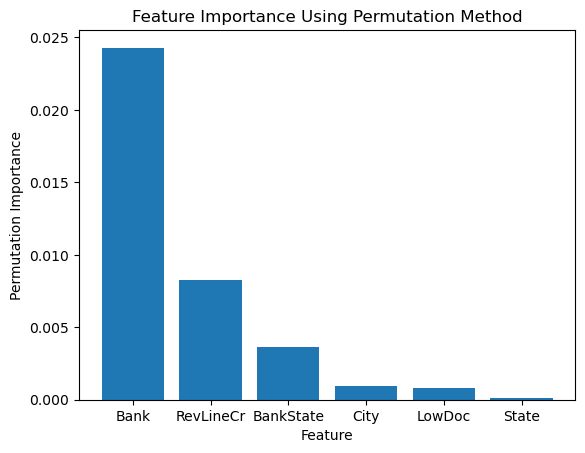

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, make_scorer

# Defining the hyperparameter space
param_grid={'n_estimators' : [200], 'max_depth' : [5], 'max_features': [5],
            'max_samples': [0.6],  'bootstrap': [True]}

# Defining the scoring metric as F1 score
f1_scorer = make_scorer(f1_score, average='weighted')

# Initializing the Decision Tree model
rf = RandomForestClassifier()

# Performing Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, scoring=f1_scorer, cv = 3, random_state=0, n_jobs = -1)

# Retraining the model with best params identified in the random search
rf_random.fit(fullDataX, fullDataY)

# Using the best model from grid search
best_rf = rf_random.best_estimator_

# Calculate permutation importance using the best model
result = permutation_importance(best_rf, X_test_te, y_test, n_repeats=30, random_state=42)

feature_importances = result.importances_mean
feature_names = fullDataX.columns

for feature, importance in zip(feature_names, feature_importances):
    print(f'{feature}: {importance}')

# Plotting feature importances
sorted_idx = feature_importances.argsort()[::-1]
plt.bar(range(fullDataX.shape[1]), feature_importances[sorted_idx], tick_label=feature_names[sorted_idx])
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Feature Importance Using Permutation Method')
plt.show()